# Load libraries

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf

import os
import json

from matplotlib import pyplot as plt

# Load configurations

In [5]:
# Participant to process
USER = 'participant11'

# Collection dataset
# COLLECTION = '2-person'
# COLLECTION = '10-person'
COLLECTION = '3-person'

# Define base path
base_data_path = '/workspaces/data'
base_path = f'{base_data_path}/0raw'

# Participant dictionary
participant_dictionary = json.load(
  open(f'{base_path}/{COLLECTION}/participant_dictionary.json')
)
user_id = participant_dictionary[USER]['fonlog_id']
start_date = participant_dictionary[USER]['start_date']
end_date_plus_one = participant_dictionary[USER]['end_date_plus_one']
end_date_plus_two = participant_dictionary[USER]['end_date_plus_two']

# Garmin

In [6]:
def checker(df):
  print((df.index.max() - df.index.min()).days + 1)

## Heart Rate

In [7]:
heart_rate = pd.read_excel(f'{base_path}/{COLLECTION}/{USER}.xlsx',
                           sheet_name='Heart Rate', index_col='Timestamp',
                           engine='openpyxl')
heart_rate.sort_values('Timestamp', inplace=True)
heart_rate = heart_rate.loc[start_date:end_date_plus_one].rename(
  columns={'Heart Rate (in Beats per minute)': 'heart_rate'}
)

checker(heart_rate)

13


## Steps

In [8]:
steps = pd.read_excel(f'{base_path}/{COLLECTION}/{USER}.xlsx',
                      sheet_name='Steps', index_col='Timestamp',
                      engine='openpyxl')
steps.sort_values('Timestamp', inplace=True)
steps = steps.loc[start_date:end_date_plus_one].rename(
  columns={'Number of Steps': 'steps'}
)

checker(steps)

13


## Stress

In [9]:
stress = pd.read_excel(f'{base_path}/{COLLECTION}/{USER}.xlsx',
                       sheet_name='Stress', index_col='Timestamp',
                       engine='openpyxl')
stress.sort_values('Timestamp', inplace=True)
stress = stress.loc[start_date:end_date_plus_one].rename(
  columns={
    'Stress Score': 'stress_score',
    'Stress Interpretation': 'stress_interpretation'
  }
)

checker(stress)

13


## Sleep

In [10]:
sleep = pd.read_excel(f'{base_path}/{COLLECTION}/{USER}.xlsx',
                      sheet_name='Sleep', index_col='Calendar Date',
                      engine='openpyxl')
sleep.sort_values('Start Time', inplace=True)
sleep = sleep.loc[start_date:end_date_plus_one]

## Combine Garmin dataset

In [12]:
# Assign participant
heart_rate = heart_rate.assign(participant=USER)
steps = steps.assign(participant=USER)
stress = stress.assign(participant=USER)
sleep = sleep.assign(participant=USER)

# Save Garmin data to Excel file
#   If the Excel file exists, append to the existing file
#   If the Excel file does not exist, create a new file
garmin_file = f'{base_data_path}/{COLLECTION}/garmin.xlsx'
if os.path.exists(garmin_file):
  with pd.ExcelWriter(garmin_file, mode='a', if_sheet_exists='overlay') as writer:
    heart_rate.reset_index().to_excel(
      writer, sheet_name='heart_rate',
      startrow=writer.sheets['heart_rate'].max_row,
      header=None, index=False
    )
    steps.reset_index().to_excel(
      writer, sheet_name='steps',
      startrow=writer.sheets['steps'].max_row,
      header=None, index=False
    )
    stress.reset_index().to_excel(
      writer, sheet_name='stress',
      startrow=writer.sheets['stress'].max_row,
      header=None, index=False
    )
    sleep.reset_index().to_excel(
      writer, sheet_name='sleep',
      startrow=writer.sheets['sleep'].max_row,
      header=None, index=False
    )
else:
  with pd.ExcelWriter(garmin_file) as writer:
    heart_rate.to_excel(writer, sheet_name='heart_rate')
    steps.to_excel(writer, sheet_name='steps')
    stress.to_excel(writer, sheet_name='stress')
    sleep.to_excel(writer, sheet_name='sleep')

# FonLog

## Wearing-Off Dataset

In [ ]:
# New FonLog server (https://nurse-kitakyu.fonlog.com/)
# activity_type_id = 12 # 17
# activity_type_group_name = 'Wearing-Off for PD' # 'Wearing-Off by Nurse'
# user_column = 'activity_target.customer_id'

# Old FonLog server (https://noelact.sozolab.jp)
activity_type_id = 2
activity_type_group_name = 'Wearing-off Questionnaire (WOQ)'
user_column = 'activity_target.user_id'

fonlog_data = pd.read_excel(f'{base_path}/{COLLECTION}/records.xlsx',
                            sheet_name='records', engine='openpyxl')

# Make sure to use datetime data type
fonlog_data['activity.started_at'] = pd.to_datetime(
    fonlog_data['activity.started_at'])
fonlog_data['activity.finished_at'] = pd.to_datetime(
    fonlog_data['activity.finished_at'])

# Filter data
filtered_fonlog_data = fonlog_data.loc[
  (fonlog_data[user_column] == user_id) &
  (fonlog_data['activity_type_group.name'] == activity_type_group_name) &
  (fonlog_data['activity.started_at'] >= start_date) &
  (fonlog_data['activity.started_at'] < end_date_plus_two) &
  (fonlog_data['record_type.activity_type_id'] == activity_type_id)
]
grouped_fonlog_data = filtered_fonlog_data.groupby(
    ['activity_target.activity_id'])

# Extract wearing-off periods
#   Drop the extra column 'activity_target.activity_id'
#   Then, rename remaining columns and the index column
wearing_off_periods = grouped_fonlog_data.agg({
  'activity.started_at': 'min',
  'activity.finished_at': 'max',
  'activity_target.activity_id': 'nunique'
}).drop(columns='activity_target.activity_id').rename(
  columns={
    "activity.started_at": "started_at",
    "activity.finished_at": "finished_at",
  }
).rename_axis('wearing_off_id')

# Add additional minutes when started_at and finished_at are the same
add_minutes = 15
wearing_off_periods.loc[
  wearing_off_periods['started_at'] == wearing_off_periods['finished_at'],
  'finished_at'
] += pd.Timedelta(minutes=add_minutes)

### Add symptom dataset

In [ ]:
# Load symptoms dictionary
symptoms_dictionary = participant_dictionary = json.load(
  open(f'{base_path}/symptom_dictionary.json')
)

# Pivot filtered fonlog data where
#   index is activity_target.activity_id (or wearing_off_id)
#   columns is record_type.name (or symptoms)
#   values is value (actual chosen value whether yes / no)
wearing_off_symptoms = filtered_fonlog_data.pivot(
  index='activity_target.activity_id',
  columns='record_type.name',
  values='value'
).rename(
  columns=symptoms_dictionary
).drop(
  columns='共有したい他の症状はありますか？'
)

# - Merge wearing_off_periods and wearing_off_symptoms
# - Fill NaN with 0
# - Replace 'ある' with 1 and 'ない' with 0
wearing_off_periods = wearing_off_periods.merge(
  wearing_off_symptoms,
  left_on='wearing_off_id',
  right_index=True
).fillna(0).replace({'ある': 1, 'ない': 0})

### Remove overarching wearing-off periods when smaller wearing-off periods exists
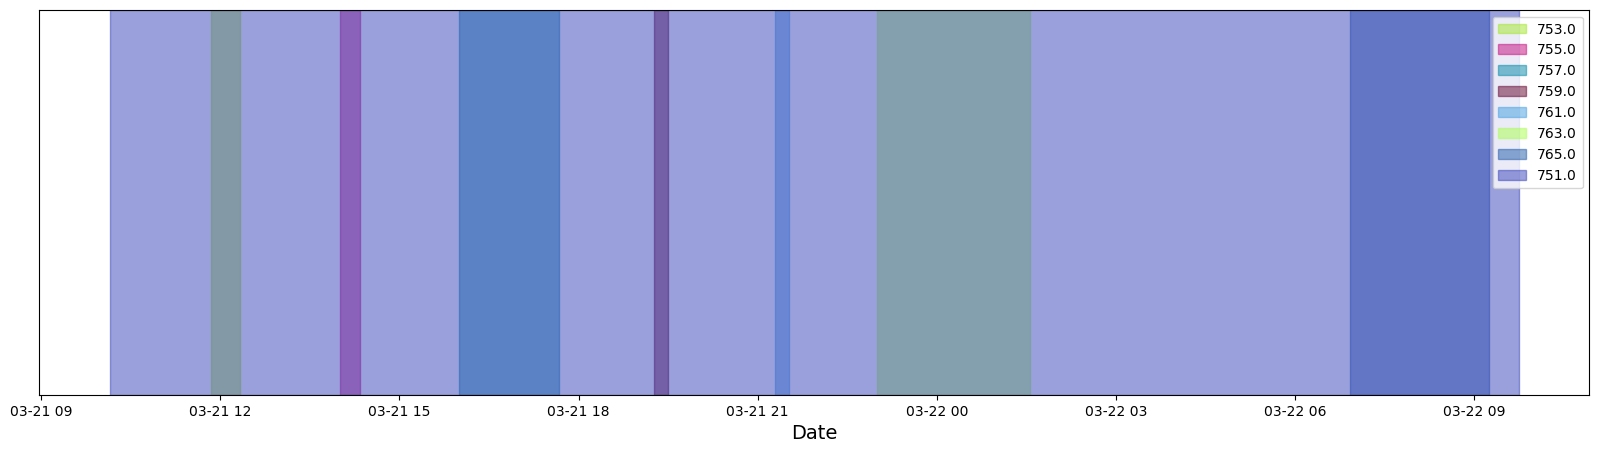

In [ ]:
# Plot a shade of the wearing-off periods based on the started_at & finished_at
#   with wearing-off period index == 753, 755, 757, 759, 761, 763, 765, 751
#   with the randomly different color per different wearing_off_id
#   and the label based on the wearing_off_id

# # Create a figure and an axes
# fig, ax = plt.subplots(figsize=(20, 5))

# # Plot the data
# tmp = wearing_off_periods.loc[[753, 755, 757, 759, 761, 763, 765, 751]]
# for wearing_off_id, wearing_off_period in tmp.iterrows():
#     ax.axvspan(
#         wearing_off_period['started_at'],
#         wearing_off_period['finished_at'],
#         alpha=0.5,
#         color=np.random.rand(3,),
#         label=wearing_off_id
#     )

# # Set the x-axis label
# ax.set_xlabel('Date', fontsize=14)

# # Remove y-axis ticks
# ax.set_yticks([])

# # Set the legend
# ax.legend()

# # Show the plot
# plt.show()

In [ ]:
def pysqldf(q): return sqldf(q, globals())


cond_join = '''
  select distinct
    wearing_off_2.[wearing_off_id] as for_remove_id
  from wearing_off_periods as wearing_off_1
  join wearing_off_periods as wearing_off_2
    on (wearing_off_2.[started_at] < wearing_off_1.[finished_at] AND 
      wearing_off_2.[started_at] < wearing_off_1.[started_at]) AND
    (wearing_off_2.[finished_at] > wearing_off_1.[finished_at] AND
      wearing_off_2.[finished_at] > wearing_off_1.[started_at]) AND
    (wearing_off_1.[wearing_off_id] <> wearing_off_2.[wearing_off_id])
'''
for_remove_ids = pysqldf(cond_join)

# Remove wearing-off periods that are included in the for_remove_ids
wearing_off_periods = wearing_off_periods[
  ~wearing_off_periods.index.isin(for_remove_ids['for_remove_id'])
]

### Save to file

In [ ]:
# Assign participant
wearing_off_periods = wearing_off_periods.assign(participant=USER)

# Save wearing_off_periods to Excel file
#  If the Excel file exists, append to the existing file
#  If the Excel file does not exist, create a new file
wearing_off_periods_file = f'{base_data_path}/{COLLECTION}/wearing_off_periods.xlsx'
if os.path.exists(wearing_off_periods_file):
  with pd.ExcelWriter(wearing_off_periods_file, mode='a', if_sheet_exists='overlay') as writer:
    wearing_off_periods.reset_index().to_excel(
      writer, sheet_name='wearing_off_periods',
      startrow=writer.sheets['wearing_off_periods'].max_row,
      header=None, index=False
    )
else:
  with pd.ExcelWriter(wearing_off_periods_file) as writer:
    wearing_off_periods.to_excel(writer, sheet_name='wearing_off_periods')

## Drug Intake Dataset

In [ ]:
# New FonLog server (https://nurse-kitakyu.fonlog.com/)
# activity_type_id = 13
# activity_type_group_name = 'Wearing-Off for PD' # 'Wearing-Off by Nurse'
# user_column = 'activity_target.customer_id'

# Old FonLog server (https://noelact.sozolab.jp)
activity_type_id = 3
activity_type_group_name = 'Wearing-off Questionnaire (WOQ)'
user_column = 'activity_target.user_id'

fonlog_data = pd.read_excel(f'{base_path}/{COLLECTION}/records.xlsx',
                            sheet_name='records', engine='openpyxl')

# Make sure to use datetime data type
fonlog_data['activity.started_at'] = pd.to_datetime(
    fonlog_data['activity.started_at'])
fonlog_data['activity.finished_at'] = pd.to_datetime(
    fonlog_data['activity.finished_at'])

# Filter data
filtered_fonlog_data = fonlog_data.loc[
    (fonlog_data[user_column] == user_id) &
    (fonlog_data['activity_type_group.name'] == activity_type_group_name) &
    (fonlog_data['activity.started_at'] >= start_date) &
    (fonlog_data['activity.started_at'] < end_date_plus_two) &
    (fonlog_data['record_type.activity_type_id'] == activity_type_id)
]
grouped_fonlog_data = filtered_fonlog_data.groupby(
    'activity_target.activity_id')

# Extract drug intake times
#   Drop the extract column 'activity_target.activity_id'
#   Then, rename the remaining columns and the index column
drug_intake_times = grouped_fonlog_data.agg({
  'activity.started_at': 'min',
  'activity.finished_at': 'max',
  'activity_target.activity_id': 'nunique'
}).drop(columns='activity_target.activity_id').rename(
  columns={
    'activity.started_at': 'started_at',
    'activity.finished_at': 'finished_at'
  }
).rename_axis('drug_intake_id')

### Add symptom dataset

In [ ]:
# Load symptoms dictionary
symptoms_dictionary = participant_dictionary = json.load(
  open(f'{base_path}/symptom_dictionary.json')
)

# Pivot filtered fonlog data where
#   index is activity_target.activity_id (or wearing_off_id)
#   columns is record_type.name (or symptoms)
#   values is value (actual chosen value whether subside / did not subside)
drug_intake_symptoms = filtered_fonlog_data.pivot(
  index='activity_target.activity_id',
  columns='record_type.name',
  values='value'
).rename(
  columns=symptoms_dictionary
)

# - Merge drug_intake_times and drug_intake_symptoms
# - Fill NaN with 0
# - Replace '飲めば経くなる' with 0
# - Replace '飲んでも変わらない' with 1
drug_intake_with_symptoms = drug_intake_times.merge(
  drug_intake_symptoms,
  left_on='drug_intake_id',
  right_index=True
).fillna(0).replace({
  '飲めば経くなる': 0,
  '飲んでも変わらない': 1,
  'ある': 1,
  'ない': 0
})

### Remove overarching drug intake times when smaller drug intake times exists

In [ ]:
def pysqldf(q): return sqldf(q, globals())


cond_join = '''
  select distinct
    drug_intake_2.[drug_intake_id] as for_remove_id
  from drug_intake_with_symptoms as drug_intake_1
  join drug_intake_with_symptoms as drug_intake_2
    on (drug_intake_2.[started_at] < drug_intake_1.[finished_at] AND 
      drug_intake_2.[started_at] < drug_intake_1.[started_at]) AND
    (drug_intake_2.[finished_at] > drug_intake_1.[finished_at] AND
      drug_intake_2.[finished_at] > drug_intake_1.[started_at]) AND
    (drug_intake_1.[drug_intake_id] <> drug_intake_2.[drug_intake_id])
'''
for_remove_ids = pysqldf(cond_join)

# Remove wearing-off periods that are included in the for_remove_ids
drug_intake_with_symptoms = drug_intake_with_symptoms[
  ~drug_intake_with_symptoms.index.isin(for_remove_ids['for_remove_id'])
]

### Save to file

In [ ]:
# Remove finished_at at drug_intake_with_symptoms
drug_intake_with_symptoms = drug_intake_with_symptoms.drop(
  columns='finished_at')

# Assign participant
drug_intake_with_symptoms = drug_intake_with_symptoms.assign(participant=USER)

# Save drug_intake_with_symptoms to Excel file
#  If the Excel file exists, append to the existing file
#  If the Excel file does not exist, create a new file
drug_intake_with_symptoms_file = f'{base_data_path}/{COLLECTION}/drug_intake_with_symptoms.xlsx'
if os.path.exists(drug_intake_with_symptoms_file):
  with pd.ExcelWriter(drug_intake_with_symptoms_file, mode='a', if_sheet_exists='overlay') as writer:
    drug_intake_with_symptoms.reset_index().to_excel(
      writer, sheet_name='drug_intake_with_symptoms',
      startrow=writer.sheets['drug_intake_with_symptoms'].max_row,
      header=None, index=False
    )
else:
  with pd.ExcelWriter(drug_intake_with_symptoms_file) as writer:
    drug_intake_with_symptoms.to_excel(
      writer, sheet_name='drug_intake_with_symptoms')